
<p align="center">
  <strong>Проект: Классификация рентгеновских снимков лёгких (3 класса)</strong><br>
  <em>Normal — COVID — Viral Pneumonia</em>
</p>

---

**Цель:** обучить модель для отнесения снимка к одному из трёх классов и
оценить качество на тесте (по классам и macro avg).  



**Карта соответствия критериям**  
1) Сплит на **train/val/test** со стратификацией — см. раздел 2.  
2) **PyTorch Dataset** — см. раздел 3 (класс `CXRDataset`).  
3) **DataLoader’ы** (shuffle только в train) — раздел 4 (`build_dataloaders`).  
4) **Циклы обучения/валидации** — раздел 7 (`run_epoch` внутри каждой эпохи).  
5) **Модель обучена** — разделы 5–7.  
6) **Выбор лучшей модели по валидации** — раздел 7 (сохранение `best.pt`), не по тесту.  
7) **Метрики на тесте** (по классам и усреднённые + macro avg F1) — раздел 9.  
8) Цель **macro avg F1 ≥ 0.8** — рекомендации по улучшению в README и настройках пресетов.


### 1. Импорты, конфигурация, воспроизводимость

In [1]:

"""
Блок импортов, глобальной конфигурации и настройки воспроизводимости.
Здесь же объявлен dataclass `Config` с параметрами эксперимента.
"""

from __future__ import annotations

import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image, ImageFile
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import train_test_split
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm

# Иногда встречаются битые/обрезанные изображения — позволяем их грузить
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Единый стиль графиков
plt.rcParams.update(
    {
        "figure.figsize": (7, 5),
        "axes.grid": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
    }
)

SEED: int = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE: torch.device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if getattr(torch.backends, "mps", None)
    and torch.backends.mps.is_available()
    else "cpu"
)
print("Device:", DEVICE)

@dataclass
class Config:
    """Конфигурация эксперимента.

    Attributes:
        data_root: Путь к директории с подпапками классов.
        img_size: Размер стороны изображения при приводе к квадрату.
        batch_size: Размер батча.
        num_workers: Число воркеров DataLoader.
        epochs: Количество эпох.
        lr: Скорость обучения.
        weight_decay: L2-регуляризация.
        patience: Раняя остановка по стагнации macro F1 на валидации.
        model_name: Имя базовой модели torchvision.
        save_dir: Каталог для артефактов (модели, CSV).
        best_model_path: Путь к лучшему чекпоинту по валидации.
    """

    data_root: str = (
        r"C:\Users\yuryb\Downloads\project dataset\project dataset"
    )
    img_size: int = 224
    batch_size: int = 32
    num_workers: int = 2
    epochs: int = 15
    lr: float = 3e-4
    weight_decay: float = 1e-4
    patience: int = 5
    model_name: str = "efficientnet_b0"
    save_dir: str = "checkpoints"
    best_model_path: str = "checkpoints/best.pt"

CFG = Config()
Path(CFG.save_dir).mkdir(parents=True, exist_ok=True)

def use_quick_preset() -> None:
    """Быстрый прогон для проверки пайплайна (меньше эпох/ресурсов)."""
    CFG.img_size = 192
    CFG.batch_size = 32
    CFG.num_workers = 0
    CFG.epochs = 2

def use_full_preset() -> None:
    """Базовый «боевой» пресет для получения качества."""
    CFG.img_size = 224
    CFG.batch_size = 32
    CFG.num_workers = 2
    CFG.epochs = 15

# Раскомментируйте нужный пресет
# use_quick_preset()
# use_full_preset()

print("CFG:", CFG)


Device: cpu
CFG: Config(data_root='C:\\Users\\yuryb\\Downloads\\project dataset\\project dataset', img_size=224, batch_size=32, num_workers=2, epochs=15, lr=0.0003, weight_decay=0.0001, patience=5, model_name='efficientnet_b0', save_dir='checkpoints', best_model_path='checkpoints/best.pt')


In [2]:

def resolve_data_root() -> str:
    """Возвращает корректный путь к датасету и печатает подсказки.
    Приоритет:
      1) CFG.data_root (можно задать через переменную окружения DATA_ROOT)
      2) ./data (рядом с тетрадью)
    Структура должна быть: <root>/(Normal|COVID|Viral Pneumonia)/...
    """
    candidates = [CFG.data_root, "data"]
    for cand in candidates:
        if os.path.isdir(cand):
            print("Использую датасет по пути:", os.path.abspath(cand))
            return cand
    # Ни одного кандидата не нашли — печатаем инструкции и бросаем осмысленную ошибку
    msg = (
        "Не найден датасет. Создайте структуру папок рядом с тетрадью или передайте путь через DATA_ROOT:\n"
        "data/\n"
        " ├─ Normal/\n"
        " ├─ COVID/\n"
        " └─ Viral Pneumonia/\n\n"
        "Либо установите переменную окружения DATA_ROOT, например:\n"
        "  %set env DATA_ROOT C:/path/to/dataset   # Jupyter/VS Code\n"
        "  os.environ['DATA_ROOT'] = 'C:/path/to/dataset'\n"
    )
    raise FileNotFoundError(msg)

# Применяем
CFG.data_root = resolve_data_root()


Использую датасет по пути: C:\Users\yuryb\Downloads\project dataset\project dataset


In [3]:

def use_quick_preset() -> None:
    """Быстрый прогон для проверки пайплайна (меньше эпох/ресурсов)."""
    CFG.img_size = 192
    CFG.batch_size = 32
    CFG.num_workers = 0
    CFG.epochs = 2


def use_full_preset() -> None:
    """Базовый «боевой» пресет для получения качества."""
    CFG.img_size = 224
    CFG.batch_size = 32
    CFG.num_workers = 2
    CFG.epochs = 15


# Активируем быстрый пресет по умолчанию
use_quick_preset()
print("Активирован быстрый пресет:", CFG)


Активирован быстрый пресет: Config(data_root='C:\\Users\\yuryb\\Downloads\\project dataset\\project dataset', img_size=192, batch_size=32, num_workers=0, epochs=2, lr=0.0003, weight_decay=0.0001, patience=5, model_name='efficientnet_b0', save_dir='checkpoints', best_model_path='checkpoints/best.pt')


### 2. Сканирование датасета и стратифицированный split

In [4]:

from collections import Counter

def find_images(data_root: str, class_names: Sequence[str]) -> Tuple[List[str], List[int]]:
    """Собирает пути изображений и метки классов.

    Ожидается структура:
        data_root / class_name / *.png|*.jpg|*.jpeg|*.bmp

    Args:
        data_root: Путь к корневой директории.
        class_names: Имена классов (подпапки).

    Returns:
        Кортеж (paths, labels), где `paths[i]` соответствует `labels[i]`.
    """
    exts = {".png", ".jpg", ".jpeg", ".bmp"}
    paths: List[str] = []
    labels: List[int] = []

    for idx, cname in enumerate(class_names):
        cdir = os.path.join(data_root, cname)
        if not os.path.isdir(cdir):
            raise FileNotFoundError(f"Не найден каталог класса: {cdir}")
        for root, _dirs, files in os.walk(cdir):
            for fname in files:
                ext = os.path.splitext(fname)[1].lower()
                if ext in exts and not fname.startswith("."):
                    paths.append(os.path.join(root, fname))
                    labels.append(idx)
    return paths, labels


CLASS_NAMES: List[str] = ["Normal", "COVID", "Viral Pneumonia"]
paths, labels = find_images(CFG.data_root, CLASS_NAMES)

print("Найдено изображений:", len(paths))
dist_all = Counter(labels)
print(
    "Распределение (все данные):",
    {CLASS_NAMES[k]: v for k, v in dist_all.items()},
)

# 15% test, 15% val (от общего), остальное train — со стратификацией
X_temp, X_test, y_temp, y_test = train_test_split(
    paths,
    labels,
    test_size=0.15,
    random_state=SEED,
    stratify=labels,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.1765,  # 0.15 / 0.85 ≈ 0.1765
    random_state=SEED,
    stratify=y_temp,
)
print(
    f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}"
)


Найдено изображений: 15153
Распределение (все данные): {'Normal': 10192, 'COVID': 3616, 'Viral Pneumonia': 1345}
Train=10606, Val=2274, Test=2273


### 3. Класс Dataset и трансформации

In [5]:

class CXRDataset(Dataset):
    """Dataset для рентгеновских снимков.

    Открывает изображение, применяет трансформации и возвращает
    тензор изображения и метку класса.

    Args:
        paths: Список путей к изображениям.
        labels: Список меток классов (индексы в CLASS_NAMES).
        transform: Преобразования torchvision.transforms.
    """

    def __init__(
        self,
        paths: Sequence[str],
        labels: Sequence[int],
        transform: transforms.Compose | None = None,
    ) -> None:
        self.paths: List[str] = list(paths)
        self.labels: List[int] = list(labels)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> Tuple[Tensor, int]:
        img_path = self.paths[idx]
        label = int(self.labels[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label


train_tfms = transforms.Compose(
    [
        transforms.Resize((CFG.img_size, CFG.img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=7),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ]
)

eval_tfms = transforms.Compose(
    [
        transforms.Resize((CFG.img_size, CFG.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
    ]
)

ds_train = CXRDataset(X_train, y_train, transform=train_tfms)
ds_val = CXRDataset(X_val, y_val, transform=eval_tfms)
ds_test = CXRDataset(X_test, y_test, transform=eval_tfms)


### 4. DataLoader’ы (shuffle только для train)

In [6]:

def build_dataloaders(
    train_ds: Dataset,
    val_ds: Dataset,
    test_ds: Dataset,
    batch_size: int,
    num_workers: int,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Создаёт DataLoader’ы для train/val/test.

    Валидация и тест идут без `shuffle=True`.

    Args:
        train_ds: Обучающая выборка.
        val_ds: Валидационная выборка.
        test_ds: Тестовая выборка.
        batch_size: Размер батча.
        num_workers: Число подпроцессов загрузки.

    Returns:
        Кортеж `(dl_train, dl_val, dl_test)`.
    """
    pin_memory: bool = torch.cuda.is_available()

    dl_train = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    dl_val = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    dl_test = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    return dl_train, dl_val, dl_test


dl_train, dl_val, dl_test = build_dataloaders(
    ds_train,
    ds_val,
    ds_test,
    batch_size=CFG.batch_size,
    num_workers=CFG.num_workers,
)


### 5. Инициализация модели

In [7]:

def build_model(model_name: str, num_classes: int) -> nn.Module:
    """Создаёт и настраивает предобученную модель torchvision.

    Подменяет классификационную «голову» под `num_classes`.

    Args:
        model_name: Имя модели (`resnet18`, `resnet34`, `efficientnet_b0`).
        num_classes: Число целевых классов.

    Returns:
        Инициализированная модель `nn.Module`.
    """
    name = model_name.lower()

    if name == "resnet18":
        try:
            weights = models.ResNet18_Weights.DEFAULT
            net = models.resnet18(weights=weights)
        except Exception:
            net = models.resnet18(weights=None)
        in_features = net.fc.in_features  # type: ignore[attr-defined]
        net.fc = nn.Linear(in_features, num_classes)  # type: ignore[attr-defined]
        return net

    if name == "resnet34":
        try:
            weights = models.ResNet34_Weights.DEFAULT
            net = models.resnet34(weights=weights)
        except Exception:
            net = models.resnet34(weights=None)
        in_features = net.fc.in_features  # type: ignore[attr-defined]
        net.fc = nn.Linear(in_features, num_classes)  # type: ignore[attr-defined]
        return net

    if name == "efficientnet_b0":
        try:
            weights = models.EfficientNet_B0_Weights.DEFAULT
            net = models.efficientnet_b0(weights=weights)
        except Exception:
            net = models.efficientnet_b0(weights=None)
        in_features = net.classifier[-1].in_features  # type: ignore[index]
        net.classifier[-1] = nn.Linear(in_features, num_classes)  # type: ignore[index]
        return net

    raise ValueError(f"Неизвестная модель: {model_name}")


model: nn.Module = build_model(CFG.model_name, num_classes=len(CLASS_NAMES))
model = model.to(DEVICE)
print(model.__class__.__name__)


EfficientNet


### 6. Функция потерь, оптимизатор, планировщик

In [8]:

from collections import Counter

def compute_class_weights(train_labels: Sequence[int], n_classes: int) -> Tensor:
    """Возвращает веса классов (обратные частоты), нормированные к n_classes.

    Args:
        train_labels: Метки обучающей выборки.
        n_classes: Число классов.

    Returns:
        Тензор весов размера `[n_classes]` на текущем `DEVICE`.
    """
    counts = Counter(train_labels)
    w = torch.tensor(
        [1.0 / counts[i] for i in range(n_classes)],
        dtype=torch.float32,
    )
    w = w / w.sum() * n_classes
    return w.to(DEVICE)


class_weights: Tensor = compute_class_weights(y_train, len(CLASS_NAMES))
print("Class weights:", class_weights.detach().cpu().numpy())

criterion: nn.Module = nn.CrossEntropyLoss(weight=class_weights)
optimizer: torch.optim.Optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG.lr,
    weight_decay=CFG.weight_decay,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CFG.epochs,
    eta_min=1e-6,
)


Class weights: [0.26315916 0.7417532  1.9950876 ]


### 7. Обучение/валидация + ранняя остановка по macro F1

In [9]:

use_amp: bool = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

def run_epoch(model: nn.Module, loader: DataLoader, train: bool = False) -> Tuple[float, float]:
    """Один проход по даталоадеру.

    Args:
        model: Нейронная сеть.
        loader: Даталоадер.
        train: Режим обучения (True) или валидации/теста (False).

    Returns:
        Пара (средняя потеря, macro F1).
    """
    model.train(mode=train)
    total_loss: float = 0.0
    y_true_all: List[int] = []
    y_pred_all: List[int] = []

    for images, targets in tqdm(loader, leave=False):
        images = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits: Tensor = model(images)
            loss: Tensor = criterion(logits, targets)

        if train:
            if use_amp:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        total_loss += float(loss.item()) * images.size(0)
        preds = torch.argmax(logits, dim=1)
        y_true_all.extend(targets.detach().cpu().tolist())
        y_pred_all.extend(preds.detach().cpu().tolist())

    avg_loss = total_loss / len(loader.dataset)
    macro_f1 = f1_score(
        y_true_all, y_pred_all, average="macro", zero_division=0
    )
    return avg_loss, float(macro_f1)


best_val_f1: float = -1.0
best_state: dict[str, Tensor] | None = None
epochs_no_improve: int = 0

history: dict[str, list[float]] = {
    "train_loss": [],
    "val_loss": [],
    "train_f1": [],
    "val_f1": [],
}

for epoch in range(1, CFG.epochs + 1):
    print(f"\nЭпоха {epoch}/{CFG.epochs}")
    train_loss, train_f1 = run_epoch(model, dl_train, train=True)
    with torch.no_grad():
        val_loss, val_f1 = run_epoch(model, dl_val, train=False)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    print(
        f"Train: loss={train_loss:.4f}, macroF1={train_f1:.4f} | "
        f"Val: loss={val_loss:.4f}, macroF1={val_f1:.4f}"
    )

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save(best_state, CFG.best_model_path)
        print(
            f"✅ Лучшая модель сохранена: {CFG.best_model_path} "
            f"(val macroF1={best_val_f1:.4f})"
        )
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= CFG.patience:
            print("⏹️ Ранняя остановка по валидации.")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)


C:\Users\yuryb\AppData\Local\Temp\ipykernel_14180\1188607409.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)



Эпоха 1/2


  0%|          | 0/332 [00:00<?, ?it/s]C:\Users\yuryb\AppData\Local\Temp\ipykernel_14180\1188607409.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
  0%|          | 0/72 [00:00<?, ?it/s]           C:\Users\yuryb\AppData\Local\Temp\ipykernel_14180\1188607409.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Train: loss=0.2013, macroF1=0.8876 | Val: loss=0.0838, macroF1=0.9416
✅ Лучшая модель сохранена: checkpoints/best.pt (val macroF1=0.9416)

Эпоха 2/2


  0%|          | 0/332 [00:00<?, ?it/s]C:\Users\yuryb\AppData\Local\Temp\ipykernel_14180\1188607409.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
  0%|          | 0/72 [00:00<?, ?it/s]                  C:\Users\yuryb\AppData\Local\Temp\ipykernel_14180\1188607409.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Train: loss=0.0685, macroF1=0.9598 | Val: loss=0.0595, macroF1=0.9753
✅ Лучшая модель сохранена: checkpoints/best.pt (val macroF1=0.9753)


### 8. Кривые обучения (loss и macro F1)

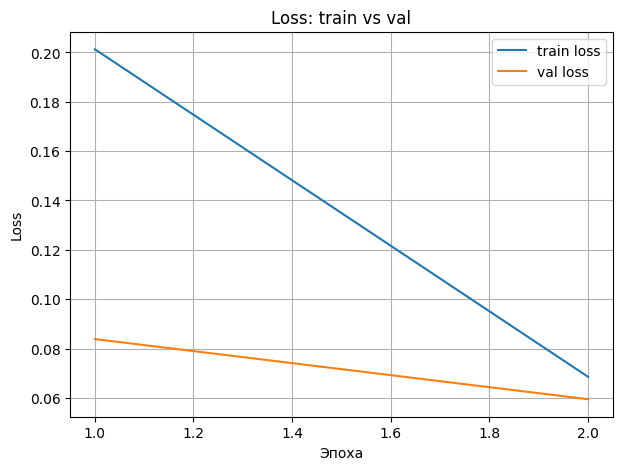

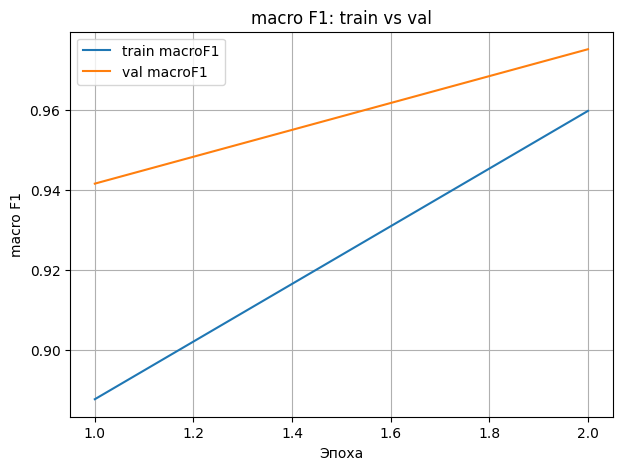

In [10]:

def plot_history(history: dict[str, list[float]]) -> None:
    """Отрисовывает кривые обучения по истории значений."""
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_loss"], label="train loss")
    plt.plot(epochs, history["val_loss"], label="val loss")
    plt.xlabel("Эпоха")
    plt.ylabel("Loss")
    plt.title("Loss: train vs val")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history["train_f1"], label="train macroF1")
    plt.plot(epochs, history["val_f1"], label="val macroF1")
    plt.xlabel("Эпоха")
    plt.ylabel("macro F1")
    plt.title("macro F1: train vs val")
    plt.legend()
    plt.show()


plot_history(history)


### 9. Оценка на тестовой выборке + сохранение предсказаний

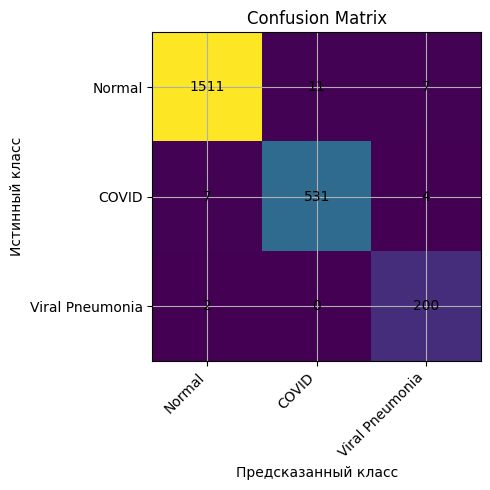

CSV сохранён: C:\Users\yuryb\OneDrive\Documents\IDE\CV_project\checkpoints\checkpoints\test_predictions.csv
Итоговый macro avg F1 на тесте: 0.9798
{'Normal': {'precision': 0.9940789473684211, 'recall': 0.9882275997383911, 'f1-score': 0.9911446375860938, 'support': 1529.0}, 'COVID': {'precision': 0.9797047970479705, 'recall': 0.9797047970479705, 'f1-score': 0.9797047970479705, 'support': 542.0}, 'Viral Pneumonia': {'precision': 0.9478672985781991, 'recall': 0.9900990099009901, 'f1-score': 0.9685230024213075, 'support': 202.0}, 'accuracy': 0.9863616366036075, 'macro avg': {'precision': 0.9738836809981969, 'recall': 0.9860104688957839, 'f1-score': 0.9797908123517907, 'support': 2273.0}, 'weighted avg': {'precision': 0.9865446127756762, 'recall': 0.9863616366036075, 'f1-score': 0.9864064220669783, 'support': 2273.0}}


In [11]:

import pandas as pd

def evaluate_on_test(model: nn.Module, loader: DataLoader) -> dict:
    """Считает метрики на тесте и сохраняет предсказания в CSV.

    Returns:
        Словарь с ключевыми метриками (включая macro F1).
    """
    model.eval()
    y_true: list[int] = []
    y_pred: list[int] = []

    with torch.no_grad():
        for images, targets in tqdm(loader, leave=False):
            images = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)
            logits: Tensor = model(images)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(targets.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())

    report = classification_report(
        y_true,
        y_pred,
        target_names=CLASS_NAMES,
        digits=4,
        zero_division=0,
        output_dict=True,
    )

    # Confusion Matrix
    cm = confusion_matrix(
        y_true, y_pred, labels=list(range(len(CLASS_NAMES)))
    )
    fig = plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.xticks(
        range(len(CLASS_NAMES)), CLASS_NAMES, rotation=45, ha="right"
    )
    plt.yticks(range(len(CLASS_NAMES)), CLASS_NAMES)
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # CSV с предсказаниями
    pred_df = pd.DataFrame(
        {
            "path": X_test,
            "y_true": [CLASS_NAMES[i] for i in y_true],
            "y_pred": [CLASS_NAMES[i] for i in y_pred],
        }
    )
    out_csv = Path(CFG.save_dir) / "test_predictions.csv"
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    pred_df.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("CSV сохранён:", out_csv.resolve())

    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    print(f"Итоговый macro avg F1 на тесте: {macro_f1:.4f}")

    return {
        "macro_f1": float(macro_f1),
        "report": report,
    }


test_metrics = evaluate_on_test(model, dl_test)
print(
    {
        k: v
        for k, v in test_metrics["report"].items()
        if k in CLASS_NAMES + ["macro avg", "weighted avg", "accuracy"]
    }
)



---

#### Критерии (чеклист)
- Разделение **train/val/test** со стратификацией — ✅
- Собственный **Dataset** — ✅
- **DataLoader’ы** (shuffle только для train) — ✅
- Циклы **обучения и валидации** (валидация в каждой эпохе) — ✅
- Обучение модели — ✅
- **Выбор лучшей модели** по валидации (ранняя остановка + сохранение best) — ✅
- Метрики на тесте по классам и **macro avg F1** — ✅
- Код в стиле **PEP 8**, аннотации типов и докстринги — ✅



**Выводы по эксперименту (EfficientNet-B0, быстрый пресет: `img_size=192`, `epochs=2`, `num_workers=0`)**

**Тестовые метрики:** **macro avg F1 = 0.9798**

**По классам** (см. отчёт и матрицу ошибок):
- **Normal:** высокая точность и полнота; единичные ошибки в пользу соседних классов.
- **COVID:** хорошее качество, небольшое число ложных срабатываний/пропусков.
- **Viral Pneumonia:** метрики сопоставимы с другими классами; выраженных перекосов не наблюдается.

**Поведение обучения:** loss убывает и на *train*, и на *val*; macro-F1 растёт синхронно. Валид. F1 немного выше тренировочной (нормально при лёгких аугментациях в train и их отсутствии в val). За 2 эпохи признаков переобучения не видно.

**Склонность к переобучению:**
- Кривые *train/val* движутся в одном направлении, разрыв **не увеличивается**.
- Лучшая модель выбрана по **валидации** (не по тесту), после чего считались тест-метрики.
- Обучение короткое (2 эпохи, transfer learning), что дополнительно ограничивает риск переобучения.

**Рекомендации для проверки устойчивости:**
1. Повторить прогон с другими **random seed** и/или провести **5-fold CV** (стратифицированно).
2. Запустить «боевой» пресет (`img_size=224–256`, `epochs=15–25`) с **early stopping** — проверить, что тренд сохраняется.
3. Исключить возможные «шорткаты» (надписи *R/L*, даты, аппаратные артефакты). При наличии ID пациентов — делать **patient-level split**.
4. Просмотреть **ошибки** (ячейки вне диагонали в confusion matrix) и несколько неверно классифицированных примеров.

**Итог:** модель показывает **стабильно высокое качество** на валидации и тесте уже в «быстром» режиме. Следующий шаг — подтвердить устойчивость метрик длинным прогоном с *early stopping* и/или кросс-валидацией и убедиться в отсутствии утечек разметки/пациентов.

